# Bank Marketing

This dataset is public available for research. The details are described in [Moro et al., 2011]. 
Please include this citation if you plan to use this database:

[Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

Available at: [pdf] http://hdl.handle.net/1822/14838
            [bib] http://www3.dsi.uminho.pt/pcortez/bib/2011-esm-1.txt

## Input variables:
### bank client data:
* 1 - age (numeric)
* 2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
* 3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
* 4 - education (categorical: "unknown","secondary","primary","tertiary")
* 5 - default: has credit in default? (binary: "yes","no")
* 6 - balance: average yearly balance, in euros (numeric) 
* 7 - housing: has housing loan? (binary: "yes","no")
* 8 - loan: has personal loan? (binary: "yes","no")

### Related with the last contact of the current campaign:
* 9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
* 10 - day: last contact day of the month (numeric)
* 11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
* 12 - duration: last contact duration, in seconds (numeric)

### Other attributes:
* 13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
* 15 - previous: number of contacts performed before this campaign and for this client (numeric)
* 16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

### Output variable (desired target):
* 17 - y - has the client subscribed a term deposit? (binary: "yes","no")

# Table of contents

* [Split Dataset train / test](#split_train_test)
* [Check for distribution mismatch between train/test set](#check_dist_mismatch)


* Check missing values
* Check correlations
* Univariate AUC
* Exploratory Decision Tree
* [Bivariate analysis](#bivariate_analysis)


* Undersample majority class
* Check for distribution mismatch between undersampled sample and population <br>

In [237]:
from IPython.display import display, HTML

import numpy as np
import bisect
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
from support_files.adversarial_validation import adversarial_validation
from support_files.categorical_dist_test import categorical_dist_test
from support_files.undersample import undersample
from support_files.statistical_preproc import univ_auc, correlation_analysis
from support_files.optimized_bins import get_optimized_bins
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize, BayesSearchCV, forest_minimize
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import graphviz
import pydotplus
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

pd.set_option("display.max_columns", 150, "display.max_colwidth", 150)
pd.options.display.max_rows = 1000

In [8]:
# Show all columns
pd.set_option('display.max_columns', None)

# Option for wider notebook cells
display(HTML(data="""
<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [151]:
dataset = pd.read_csv("./data/bank-full.csv", sep=";")

In [10]:
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [11]:
dataset["Month"] = dataset["month"].map({"jan":1, "feb":2, "mar":3, "apr":4, "may":5, "jun":6, "jul":7, "aug":8, 
                                          "sep":9, "oct":10, "nov":11, "dec":12})
dataset["default_in_loan"] = dataset["default"].map({'no':0, 'yes':1})
dataset["housing_loan"] = dataset["housing"].map({'no':0, 'yes':1})
dataset["personal_loan"] = dataset["loan"].map({'no':0, 'yes':1})
dataset["prob_outcome"] = np.where(dataset["poutcome"] == "success", 1, 0)
dataset["target"] = dataset["y"].map({'no':0, 'yes':1})

dataset = dataset.drop(["month","default","housing","loan", "poutcome","y"], axis=1)

dataset['id'] = range(len(dataset))

In [12]:
categorical_vars_t =[]
numerical_vars=[]
for i in dataset.drop(["target","id"], axis=1).columns.tolist():
    if dataset[i].dtype == 'O':
        categorical_vars_t.append(i)
    else:
        numerical_vars.append(i)

In [13]:
dataset.head()

,age,job,marital,education,balance,contact,day,duration,campaign,pdays,previous,Month,default_in_loan,housing_loan,personal_loan,prob_outcome,target,id
0,58,management,married,tertiary,2143,unknown,5,261,1,-1,0,5,0,1,0,0,0,0
1,44,technician,single,secondary,29,unknown,5,151,1,-1,0,5,0,1,0,0,0,1
2,33,entrepreneur,married,secondary,2,unknown,5,76,1,-1,0,5,0,1,1,0,0,2
3,47,blue-collar,married,unknown,1506,unknown,5,92,1,-1,0,5,0,1,0,0,0,3
4,33,unknown,single,unknown,1,unknown,5,198,1,-1,0,5,0,0,0,0,0,4


<a id='split_train_test'></a>
#### Get train and test set from the original dataset

In [14]:
X_train, X_test, y_train, y_test = train_test_split(dataset, dataset.target, test_size=0.3, random_state=55555)

In [15]:
data_train = X_train.copy().reset_index(drop=True)
data_train["target"] = y_train.reset_index(drop=True)

data_test = X_test.copy().reset_index(drop=True)
data_test["target"] = y_test.reset_index(drop=True)

In [16]:
print(data_train.target.mean())
print(data_test.target.mean())
print()
print(data_train.target.sum())
print(data_test.target.sum())

0.11748348974626346
0.11582129165437924

3718
1571


#### We need to perform 2 steps:
* We have an event rate of ~11% in both train and test samples - we will balance these samples with 2:1 odds (2 parts non-event, 1 part event)
* Then, we will perform adversarial validation on the obtained samples to check: <br>
    1 - If the samples come from the same distribution of the population they were samples from <br>
    2 - If the sampled population in the train set comes from the same distribution of the test set:
* If they don't come from the same distribution we will choose the observations more similar to the ones in the population/test set

<a id='check_dist_mismatch'></a>
## Check Distribution mismatch between train/test set

In [17]:
adv = adversarial_validation(data_train, data_test,"target", "id", 
                        RandomForestClassifier( n_estimators=200, max_depth=5, n_jobs = -1, random_state=55555 ))

In [18]:
adv_val_set, predictions = adv.check_dist()

AUC is: 0.5011083308530179


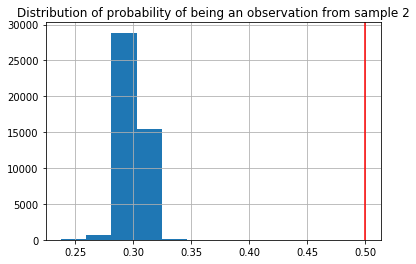

In [19]:
adv_val_set_probs = adv.get_scored_obs(adv_val_set, predictions, get_plot=True)

#### If we have different distributions on the samples we can:
* Remove observations with low probability from sample_1 (making sample_1 more similar to sample_2)
* Transfer observations with low probability on sample_1 to sample_2 (making sample_2 more similar to sample_1)
* Choose another sample_2

## Univariate analysis

#### Check for missing values

In [20]:
data_train.isnull().sum()

age                0
job                0
marital            0
education          0
balance            0
contact            0
day                0
duration           0
campaign           0
pdays              0
previous           0
Month              0
default_in_loan    0
housing_loan       0
personal_loan      0
prob_outcome       0
target             0
id                 0
admin.             0
blue-collar        0
entrepreneur       0
housemaid          0
management         0
retired            0
self-employed      0
services           0
student            0
technician         0
unemployed         0
unknown            0
dtype: int64

#### Histograms

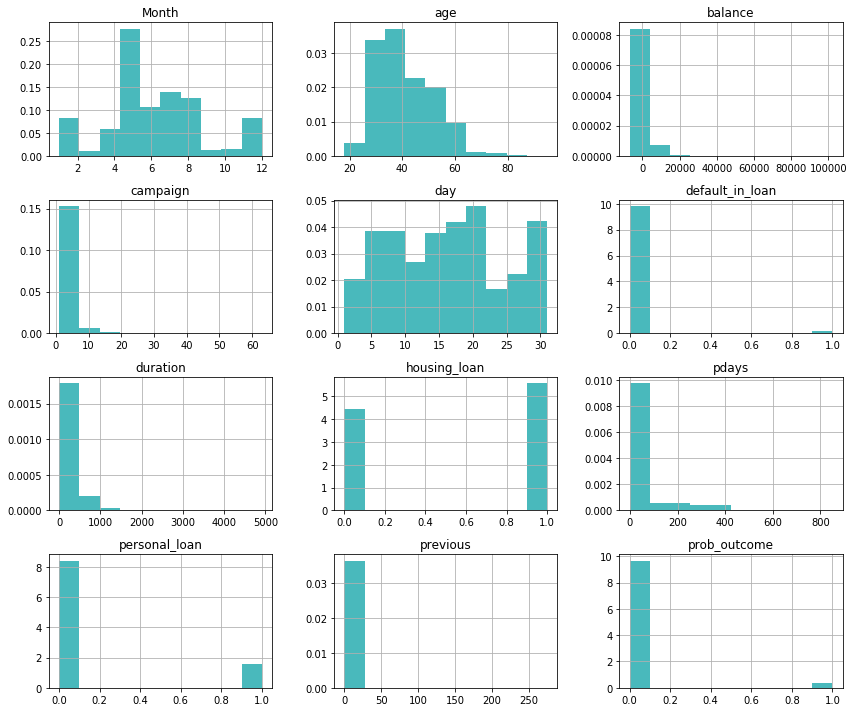

In [21]:
data_train[numerical_vars].hist(figsize=(12,10), density=True, color="#49b9bc")
plt.tight_layout()
plt.show()

<a id='bivariate_analysis'></a>
## Bivariate analysis

#### Correlation analysis

In [22]:
corr, corr_net = correlation_analysis(data_train.drop("id", axis=1), corr_limit=0.6)

In [23]:
corr

,variable 1,variable 2,correlation


In [24]:
corr_net

,Variable,# Correlations > limit


#### Univariate AUC

In [18]:
univ_auc_df = univ_auc(data_train, features, "target")

NameError: name 'features' is not defined

In [19]:
univ_auc_df[univ_auc_df["AUC"] > 0.6]

NameError: name 'univ_auc_df' is not defined

#### Exploratory Decision Tree

In [22]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(data_train[features].drop("id", axis=1), data_train.target)

In [30]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=list(data_train[features].drop("id", axis=1)),  
                         class_names=["goods", "bads"],  
                         filled=True, rounded=True,  
                         special_characters=True,
                        proportion=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  

graph.write_png('./tree.png')

True

#### Optimized bins against the event rate

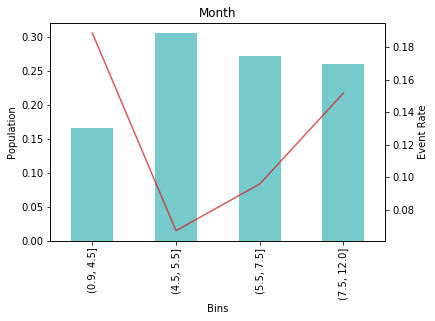

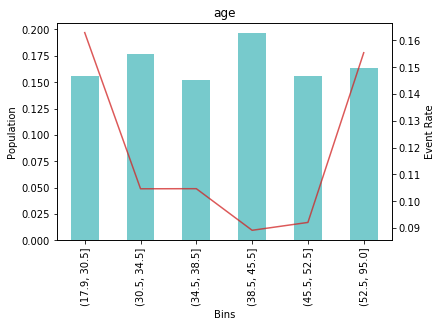

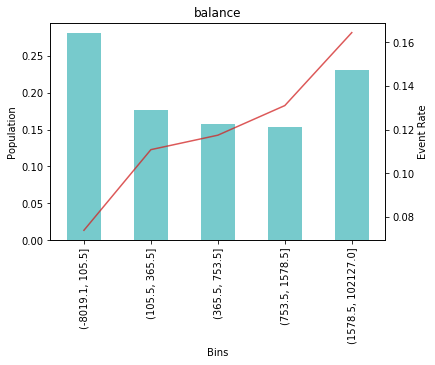

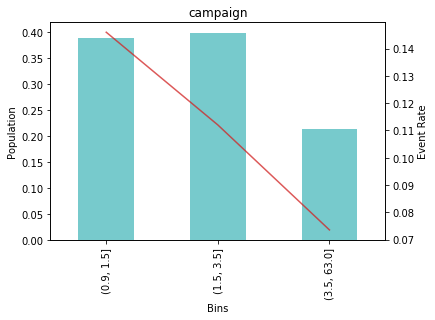

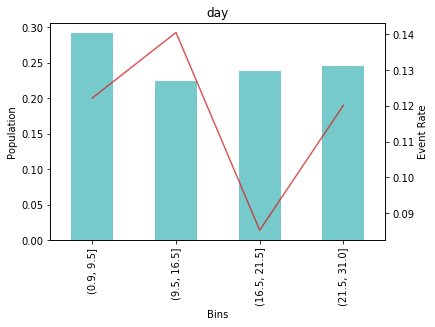

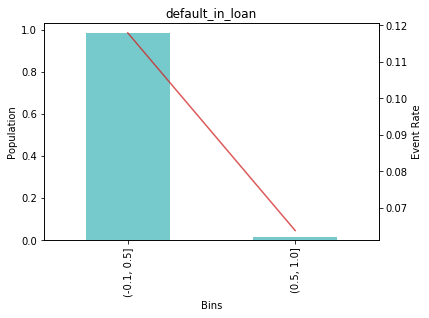

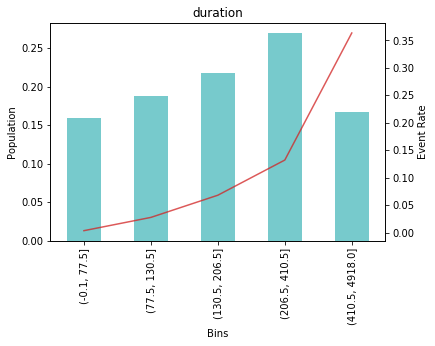

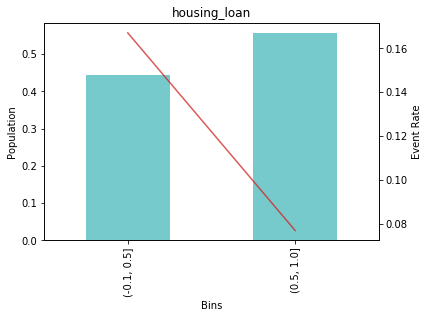

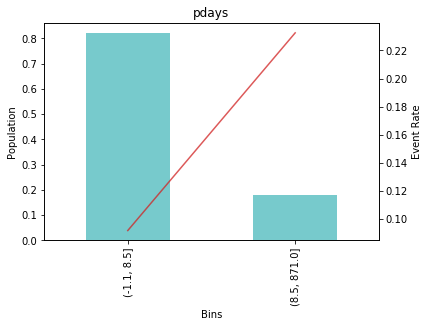

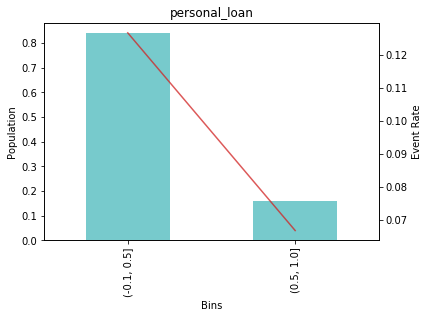

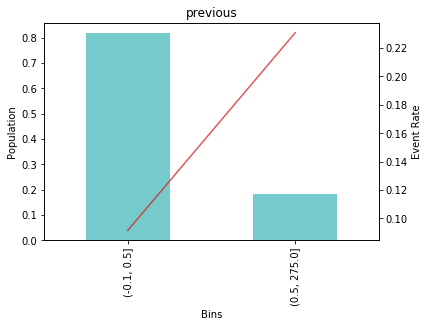

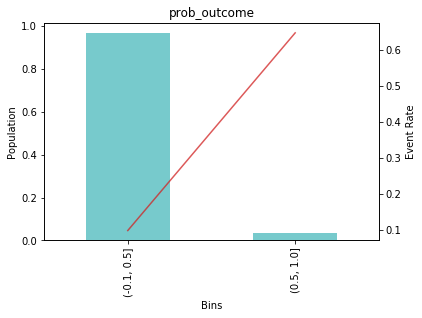

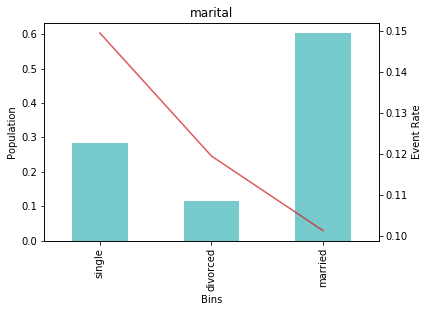

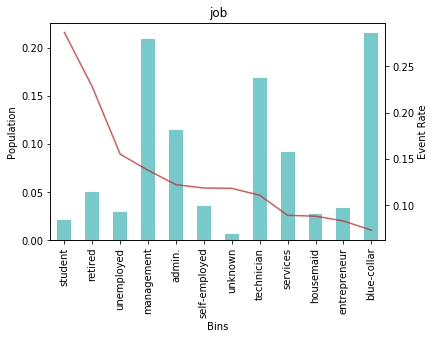

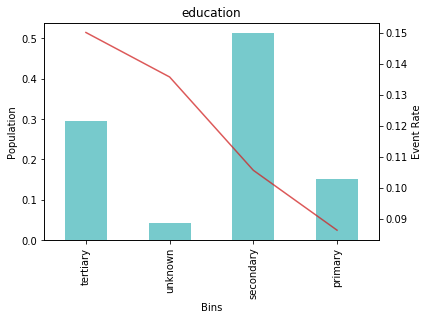

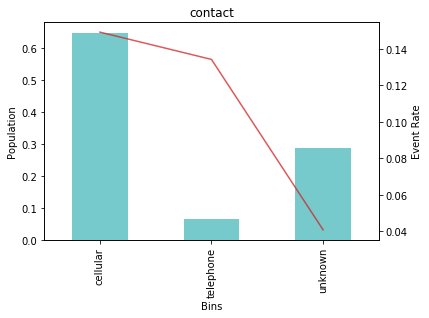

In [38]:
get_optimized_bins(dataset, "target", "id", list(dataset), min_bin_percent=0.15, get_plots=True);

## Undersample class 0
## 2:1 odds - Check for distribution mismatch

In [30]:
data_train_2_1 = undersample(data_train, "target", 2, 55555)

In [33]:
adv_2_1_sample = adversarial_validation(data_train[data_train["target"]==0], data_train_2_1[data_train_2_1["target"]==0], features,
                        "target", "id", 
                        RandomForestClassifier( n_estimators=200, max_depth=3, n_jobs = -1, random_state=55555 ))

In [34]:
adv_2_1_val_set, predictions_2_1 = adv_2_1_sample.check_dist()

AUC is: 0.4714475599783675


In [6]:
#Setup the hyperparameter grid
param_distributions = {'RF__max_depth' :  Integer(2, 5),
                        'RF__n_estimators' : Integer(50, 75)}

#Create a classifier instance
pipe_1 = Pipeline(steps=[('pca', LabelBinarizer()), 
                       ('RF', RandomForestClassifier(random_state=77777))])

#Instantiate the BayesSearchCV object
pipe_1_cv = BayesSearchCV(pipe_1, param_distributions, {'base_estimator': 'RF'}, 
                          scoring='neg_log_loss', cv=3, n_iter=30, random_state=77777)

In [41]:
cats = list(dataset.select_dtypes(include='object').columns)

In [309]:
from sklearn.base import TransformerMixin, BaseEstimator

class MyCatEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_bin = {}
    
    def fit(self, X, y=None):
        self.cats = list(X.select_dtypes(include='object').columns)
        for c in self.cats:
            self.label_bin[c] = LabelBinarizer()
            self.label_bin[c].fit(X[c])
            
            lb_classes = self.label_bin[c].classes_.tolist()
            bisect.insort_left(lb_classes, 'other')
            self.label_bin[c].classes_ = lb_classes
            
        return self
            
    def transform(self, X):
        X = X.copy()
        new_dfs = []
        for c in self.cats:
            names = [''.join([c + "==", j]) for j in self.label_bin[c].classes_]

            repl = list(set(list(X[c])) - set(list(self.label_bin[c].classes_)))
            
            if repl:
                X[c] = X[c].replace(repl, "other")
            
            arr = self.label_bin[c].transform(X[c])
            if len(names) == 2:
                arr = np.concatenate(((~arr.astype(bool)).astype(int), arr), axis=1)

            df = pd.DataFrame(arr, columns=names)
            new_dfs.append(df)
            
        dummies = pd.concat(new_dfs, axis=1)
        X = pd.concat((X, dummies), axis=1)
                           
        return X.drop(self.cats, axis=1)

In [310]:
enc = MyCatEncoder()

In [312]:
enc.fit_transform(dataset).head()

,age,balance,day,duration,campaign,pdays,previous,a,job==admin.,job==blue-collar,job==entrepreneur,job==housemaid,job==management,job==other,job==retired,job==self-employed,job==services,job==student,job==technician,job==unemployed,job==unknown,marital==divorced,marital==married,marital==other,marital==single,education==other,education==primary,education==secondary,education==tertiary,education==unknown,default==no,default==other,default==yes,housing==no,housing==other,housing==yes,loan==no,loan==other,loan==yes,contact==cellular,contact==other,contact==telephone,contact==unknown,month==apr,month==aug,month==dec,month==feb,month==jan,month==jul,month==jun,month==mar,month==may,month==nov,month==oct,month==other,month==sep,poutcome==failure,poutcome==other,poutcome==other,poutcome==success,poutcome==unknown,y==no,y==other,y==yes
0,58,2143,5,261,1,-1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
1,44,29,5,151,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
2,33,2,5,76,1,-1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
3,47,1506,5,92,1,-1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
4,33,1,5,198,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
